I got a task to review the 4 text files and 
1. Compute the most important key-words (a key-word can be between 1-3 words)
2. Choose the top n words from the previously generated list. Compare these key-
words with all the words occurring in all of the transcripts.
3. Generate a score (rank) for these top n words based on analysed transcripts.

## Data
The data is 4 wikipedia articles each relating to food. 
**script.txt** is an article about food
**transcript_1.txt** is about Fast Food
**transcript_2.txt** is about a resteraunt
**transcript_3.txt** is about Cooking

## What is important
I need to find out what the most important key words are, and also to define importance. 
Two options for what is important
1. What words identify each document
2. What words in the script "identify" it the most. This is probably better as questions 2 and 3 make more sense in this context. e.g. If we find what words predict each document what their ranking across transcripts be? What would be the difference between script and transcript

## Methods
I'll try 1, maybe 2 things (if the first doesn't work)
1. Download some other articles not related to food. Run LDA and see if we can seperate the other articles from this one. That is if we can find a topic that the **script** scores highly on and the other documents don't 




In [500]:
%pylab inline
import sklearn
import pandas as pd
import numpy as np
import nltk
import os
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [501]:
path ='./data'
d ={}
corpus = []
for name in os.listdir(path):
    if name.endswith('.txt'):
        f_path = os.path.join(path,name)
        with open(f_path) as f:
            d[name] = f.read()
            corpus+=d[name].split('.')
path+='/transcripts'
for name in os.listdir(path):
    if name.endswith('.txt'):
        f_path = os.path.join(path,name)
        with open(f_path) as f:
            d[name] = f.read()
            corpus+=d[name].split('.')

# Build a tokenizer

In [593]:
class Tokenizer():
    def __init__(self):
            self.lemma = nltk.stem.WordNetLemmatizer()
            self.stem = nltk.stem.SnowballStemmer("english")
            self.tokenizer =nltk.RegexpTokenizer(r'\w+')
            self.reg = re.compile('\d+')
    def proc_word(self,word):
        word = self.reg.sub('',word)
        word = self.lemma.lemmatize(word)
        
        return word
        
    def __call__(self,doc):
        res = [self.proc_word(word) for word in self.tokenizer.tokenize(doc.lower())]
        res = list(filter(lambda x:len(x)>3,res))
        return res

            
            

T = Tokenizer()
T("hello the man is Great")

['hello', 'great']

In [503]:
tf_vectorizer = CountVectorizer(max_df=0.75,min_df=0.25,  stop_words='english',tokenizer=Tokenizer(),ngram_range=(1,1))
tf = tf_vectorizer.fit(corpus)
tfed = tf.transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()


In [504]:
lda = LatentDirichletAllocation(n_topics=len(d)*2, max_iter=6, learning_method='online', learning_offset=50.,random_state=0).fit(tfed)


In [505]:
def build_pipeline(num_docs):
    '''

    :param args: Args passed to the command line via argparser
    :return: A pipeline that implements CountVectorizer and LDA with the args passed to argparser
    '''
    tf_vectorizer = CountVectorizer(
        max_df=0.95, #  Keep words that apear in only up to 95% of the documents (eg corpus specific stop words)
        min_df=5, # Only use words that apear in at least 5 documents
        stop_words='english',
        tokenizer=Tokenizer(), # Use our custom tokenizer
        ngram_range=(1, 3) #Use key words of length 1,2 or 3
    )

    lda = LatentDirichletAllocation(
        n_topics=num_docs , # learn twice as many document as we have documents
        max_iter=6,
        learning_method='online',
        learning_offset=50.,
         random_state=0)
    pipeline = Pipeline([('count_vectorizer', tf_vectorizer), ('lda', lda)])
    
    return pipeline


In [506]:
pipeline =build_pipeline(len(d))
model = pipeline.fit(corpus)

In [507]:
model.named_steps["count_vectorizer"].get_feature_names()

['',
 ' ',
 '  ',
 '  season',
 '  seat',
 '  year',
 ' b',
 ' bc',
 ' billion',
 ' c',
 ' c ',
 ' country',
 ' displaystyle',
 ' earliest',
 ' edit',
 ' external',
 ' external link',
 ' f',
 ' fa',
 ' food',
 ' ha',
 ' history',
 ' million',
 ' new',
 ' people',
 ' piece',
 ' pizza',
 ' r',
 ' recent',
 ' reference',
 ' reference ',
 ' restaurant',
 ' season',
 ' seat',
 ' stand',
 ' step',
 ' step ',
 ' villa',
 ' villa park',
 ' wa',
 ' wine',
 ' world',
 ' year',
 ' year ago',
 ' year old',
 'abstract',
 'ac',
 'access',
 'according',
 'account',
 'acid',
 'act',
 'activity',
 'adam',
 'added',
 'adding',
 'addition',
 'additive',
 'adult',
 'affect',
 'africa',
 'age',
 'aging',
 'ago',
 'agricultural',
 'agriculture',
 'aid',
 'air',
 'alcohol',
 'alcoholic',
 'alcoholic beverage',
 'algebraic',
 'algebraic topology',
 'allowed',
 'allows',
 'amenable',
 'america',
 'american',
 'analysis',
 'ancient',
 'animal',
 'antoine',
 'application',
 'applying',
 'approach',
 'approximate

In [533]:
def display_topics(comps, feature_names, no_top_words):
    for topic_idx, topic in enumerate(comps):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


In [536]:
no_top_words = 10
display_topics(model.named_steps["lda"].components_, model.named_steps["count_vectorizer"].get_feature_names(), no_top_words)


Topic 0:
      year wa food wine ha restaurant  year
Topic 1:
group c point d f free n rotation theorem step
Topic 2:
sugar fried measure important deep fried different salt deep transformation level
Topic 3:
 s wa new   century cup restaurant th cooking
Topic 4:
group space banach paradox tarski set algebraic banach tarski euclidean decomposition
Topic 5:
vegetable ha vitamin large including obesity industry cooking water mineral
Topic 6:
food fast fast food restaurant cooking used health pizza animal ingredient
Topic 7:
wine grape g state united united state fruit  billion billion university
Topic 8:
pizza b e meat displaystyle  origin usually variety fish
Topic 9:
stand villa end park road villa park holte trinity trinity road wa


In [532]:
model.named_steps["lda"].components_

array([[  1.02171121e+03,   2.64226770e+02,   7.53039228e+01, ...,
          1.16661028e-01,   4.01260622e+00,   1.24449240e-01],
       [  7.84177765e+00,   1.23120571e-01,   1.19044590e-01, ...,
          1.16751680e-01,   1.14512014e-01,   1.38551672e-01],
       [  8.85075738e-01,   1.21390062e-01,   1.18309658e-01, ...,
          1.21419933e-01,   1.16528792e-01,   1.17654830e-01],
       ..., 
       [  1.34361330e+01,   2.62059933e-01,   1.26800934e-01, ...,
          1.21023038e-01,   1.17561001e-01,   1.16507266e-01],
       [  2.32712906e+01,   1.52936780e-01,   1.16366473e-01, ...,
          1.17736542e-01,   1.43464882e-01,   1.36238403e-01],
       [  1.77645334e+01,   1.23497588e-01,   1.18142382e-01, ...,
          1.14824151e-01,   1.16948395e-01,   1.17024743e-01]])

In [510]:
D["script.txt"].argsort()[::-1]

9    6
8    5
7    0
6    3
5    7
4    8
3    1
2    9
1    2
0    4
Name: script.txt, dtype: int64

In [511]:
def pipeline(doc):
    res = model.transform([doc])
    return res[0]
    

In [512]:
res = {name:pipeline(doc) for name,doc in d.items()}

In [513]:
pipeline(d["pizza.txt"])[0]

0.18827788832241277

In [514]:
D =pd.DataFrame(res)

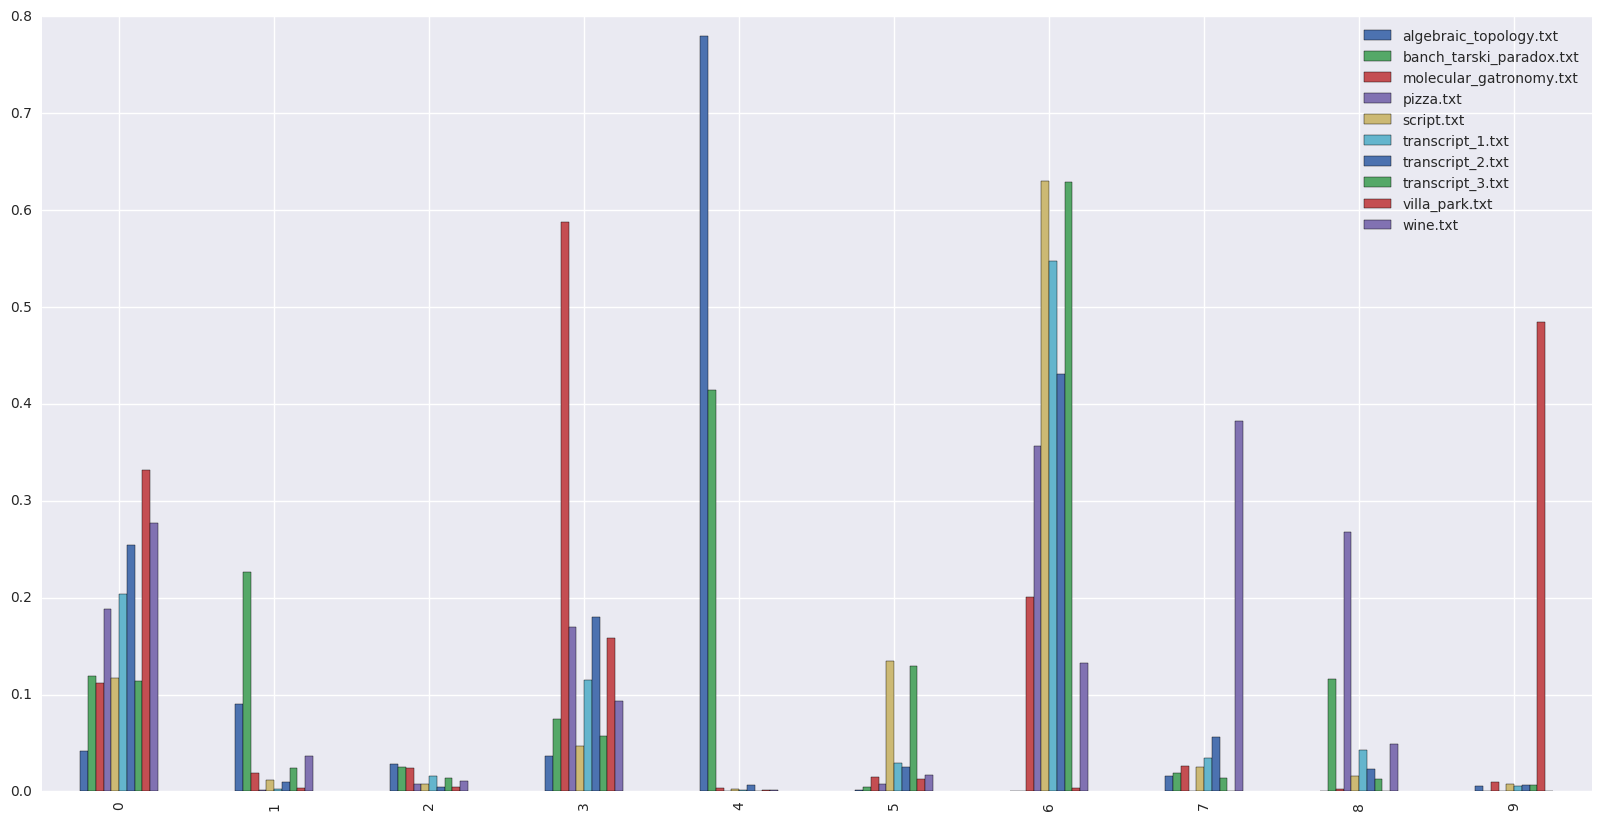

In [515]:
D.plot.bar(figsize=(20,10))

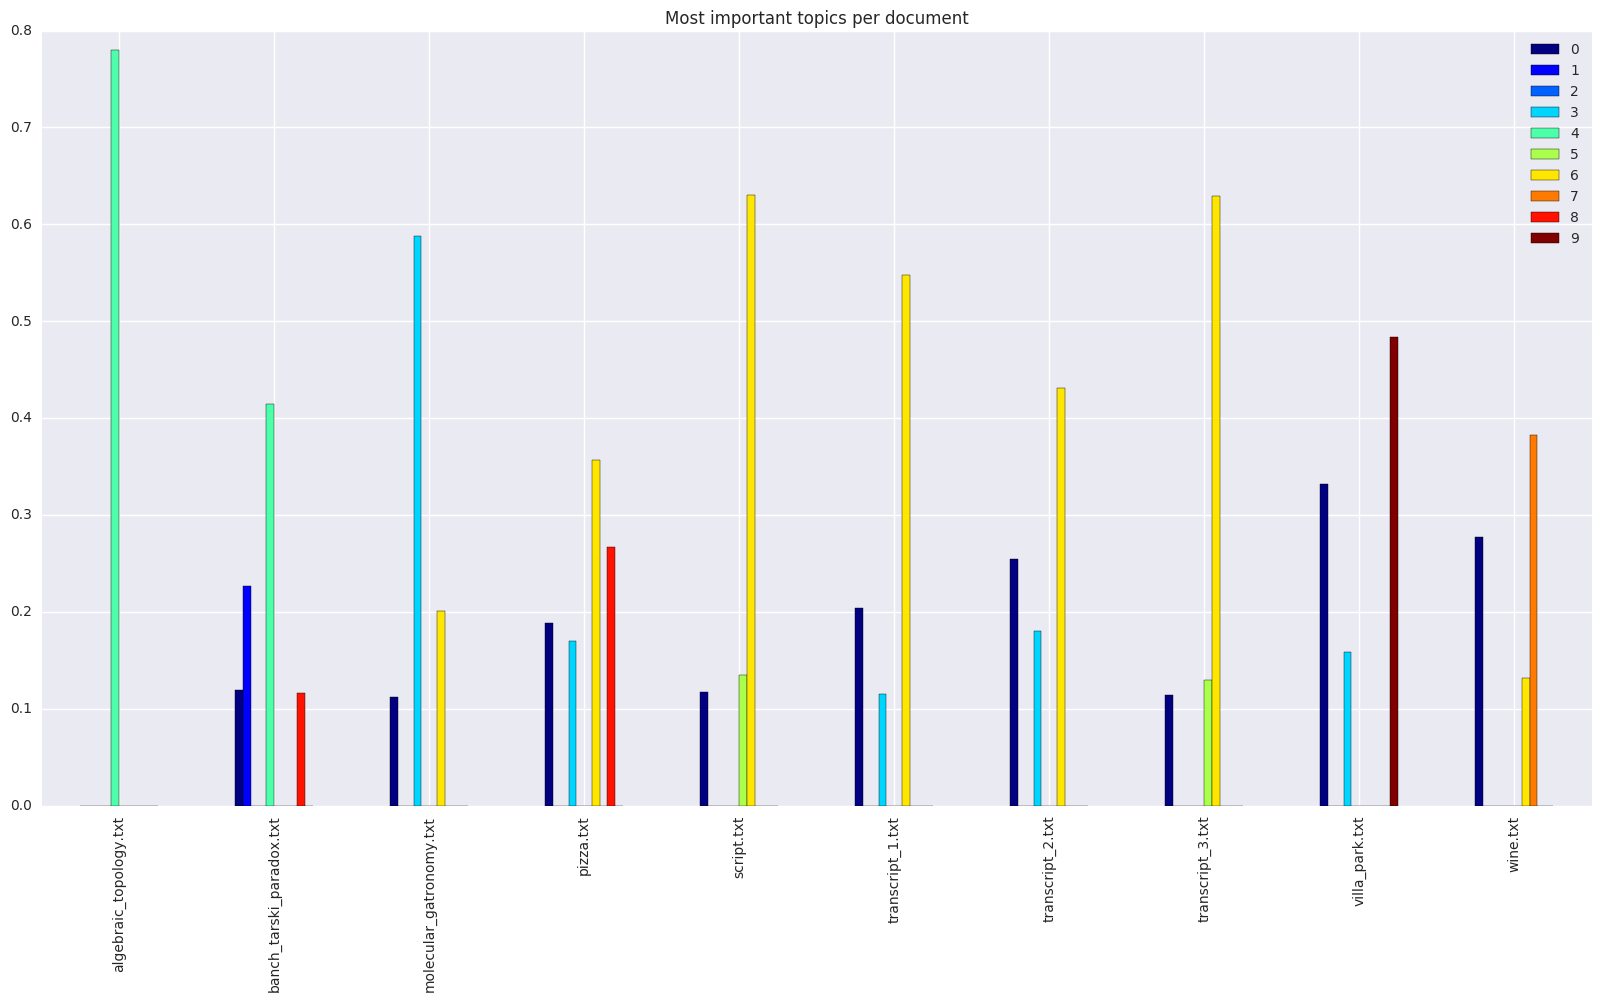

In [781]:
D[D>0.1].T.plot.bar(figsize=(20,10),colormap='jet',title="Most important topics per document")

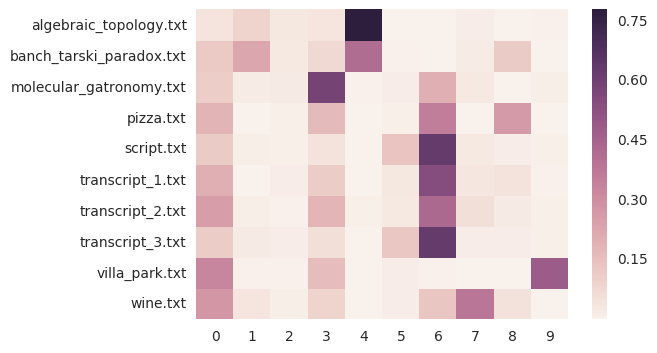

In [517]:
sns.heatmap(D.T)

In [518]:
normed = (D.T - D.T.mean())/D.T.std()

In [519]:
D

,algebraic_topology.txt,banch_tarski_paradox.txt,molecular_gatronomy.txt,pizza.txt,script.txt,transcript_1.txt,transcript_2.txt,transcript_3.txt,villa_park.txt,wine.txt
0,0.041485,0.118863,0.112368,0.188278,0.117091,0.204092,0.254821,0.113618,0.331657,0.276992
1,0.090005,0.226947,0.018855,0.001038,0.011714,0.002059,0.009726,0.023718,0.003170,0.036627
2,0.027939,0.025188,0.024058,0.007504,0.007465,0.015594,0.004935,0.014152,0.004839,0.010797
3,0.036773,0.075233,0.587501,0.169753,0.047372,0.115457,0.180344,0.056978,0.158684,0.093544
4,0.779749,0.414800,0.003518,0.000859,0.002248,0.001556,0.006864,0.000072,0.001542,0.001860
5,0.001889,0.004490,0.014883,0.008072,0.134896,0.029700,0.025385,0.129400,0.012831,0.016525
6,0.000139,0.000038,0.200718,0.356994,0.629986,0.547824,0.431183,0.629012,0.003098,0.132073
7,0.015868,0.018606,0.026288,0.000067,0.025382,0.034750,0.056659,0.013954,0.000041,0.382330
8,0.000139,0.115797,0.002411,0.267367,0.016286,0.043101,0.023323,0.012579,0.000041,0.049201
9,0.006013,0.000038,0.009402,0.000067,0.007560,0.005866,0.006760,0.006516,0.484098,0.000051


In [520]:
normed[normed>1].T

,algebraic_topology.txt,banch_tarski_paradox.txt,molecular_gatronomy.txt,pizza.txt,script.txt,transcript_1.txt,transcript_2.txt,transcript_3.txt,villa_park.txt,wine.txt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.713374,1.111934
1,NaN,2.635183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.570761,1.255122,1.125534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.695683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.482798,1.106678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,1.923811,NaN,NaN,1.814917,NaN,NaN
6,NaN,NaN,NaN,NaN,1.299712,NaN,NaN,1.295957,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.816598
8,NaN,NaN,NaN,2.581843,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.845323,NaN


In [541]:
path ='./data/transcripts'
transcripts ={}

for name in os.listdir(path):
    if name.endswith('.txt'):
        f_path = os.path.join(path,name)
        with open(f_path) as f:
            transcripts[name] = f.read()
            
    

In [522]:
transcripts = {name:pipeline(doc) for name,doc in transcripts.items()}

In [523]:
X  =pd.DataFrame(transcripts)

In [539]:
X['transcript_2.txt'].argmax()

6

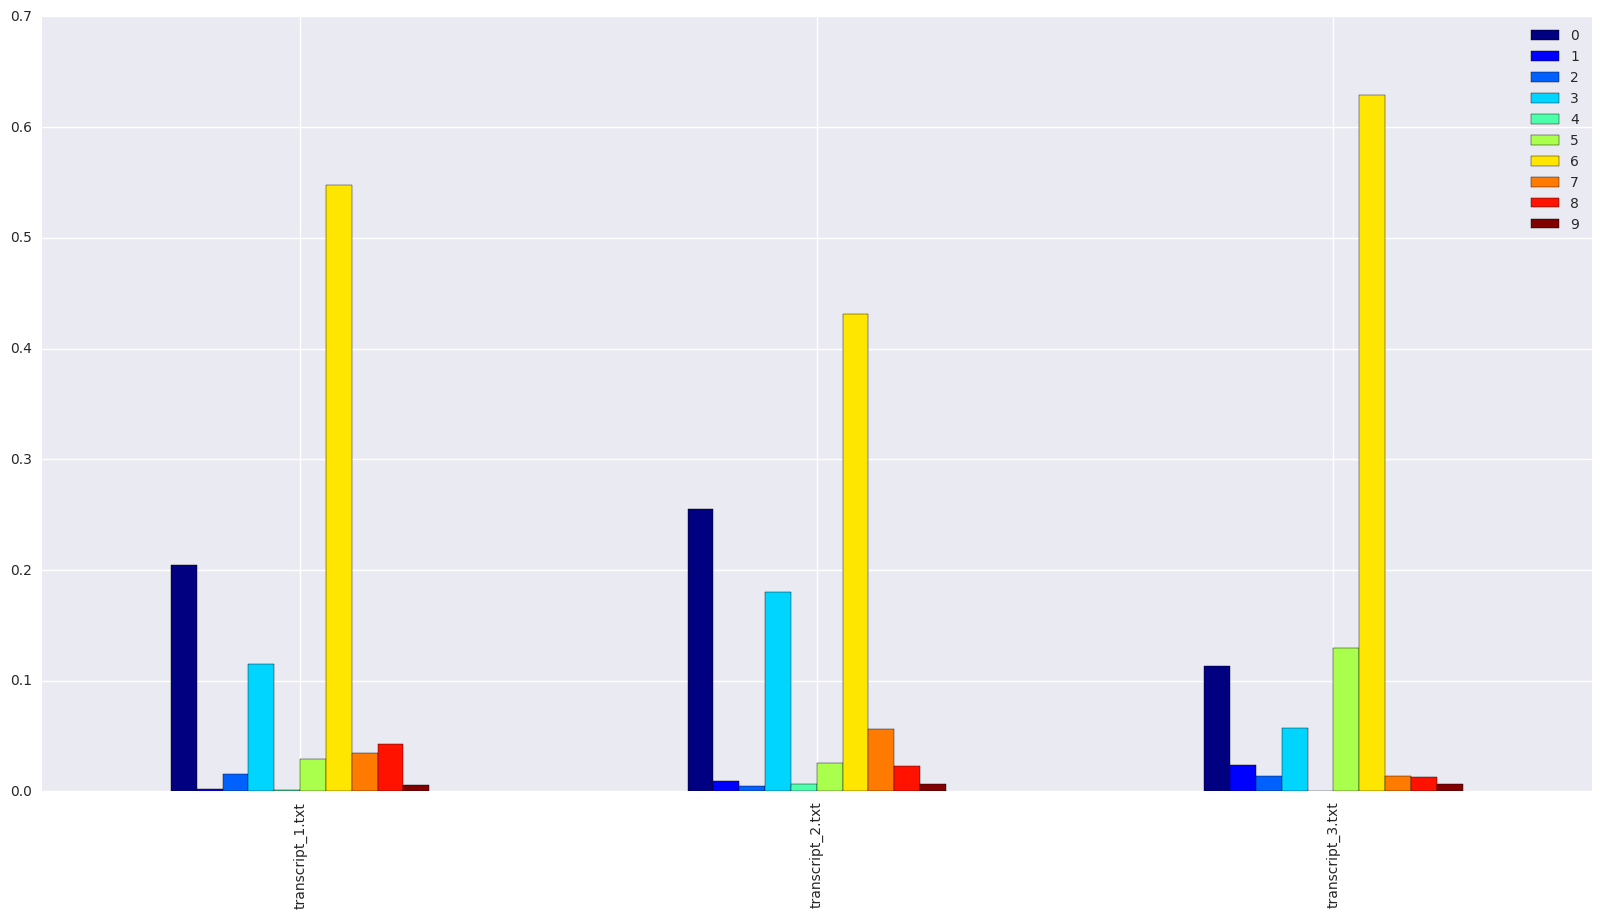

In [767]:
ax = X.T.plot.bar(figsize=(20,10),colormap='jet')

In [769]:
fig =ax.get_figure()
fig.savefig('/tmp/test.png')

# Word score
To score the words we'll use the z-score of their tf-idf score where the train corpus are the transcripts and the term frequencyies come from the script

In [790]:
corpus =[]
for key,val in transcripts.items():
    corpus+=val.splitlines()
tfidf = TfidfVectorizer(tokenizer=Tokenizer(),stop_words='english',ngram_range=(1,4),smooth_idf=True)
tf_model = tfidf.fit(corpus)
script = tf_model.transform([d["script.txt"]])
tf_feature_names = tf_model.get_feature_names()

In [791]:
def display_word_ranks(vector, feature_names, no_top_words):
    
        ranking_dict = {feature_names[i]: -np.log(vector[i]) #dictionary comprehension, key is word val is score
                   for i in vector.argsort()  # iterate over indices sorted by the value
                   if vector[i] >0 # and only take values that are non zero e.g. appear in the document
                   }
        
    
        return ranking_dict
z = script.toarray()


In [696]:
z[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [792]:
ranking_dict =(display_word_ranks(z[0],tf_feature_names,40))

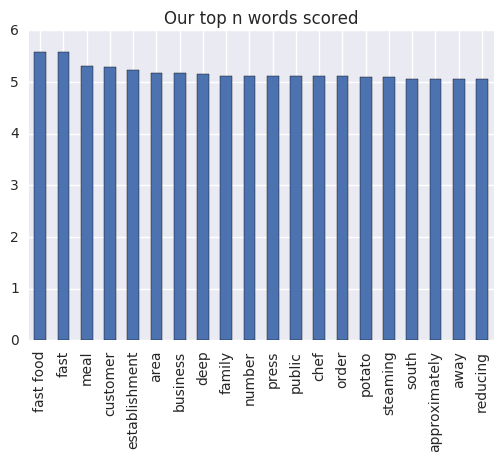

In [795]:
S = pd.Series(ranking_dict)
S = S.sort_values(ascending=False)
S[S!=S.value_counts().values[0]][:20].plot.bar(title="Our top n words scored")

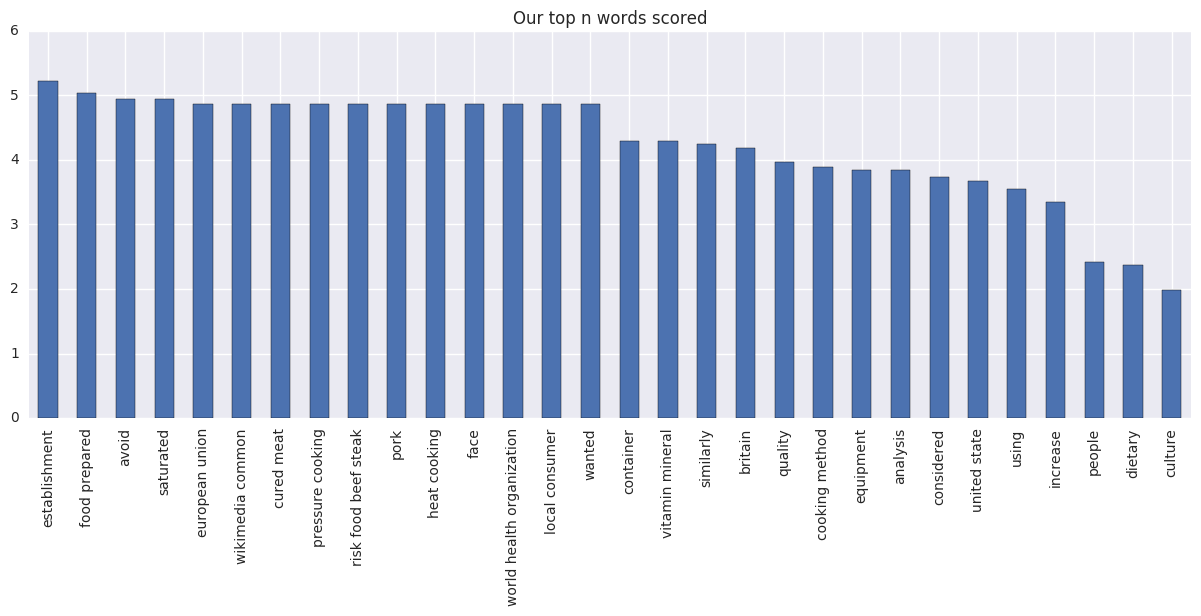

In [789]:
T =S.sample(30).index
Y = S[T]
Y.sort_values(ascending=False).plot.bar(figsize=(15,5),title="Our top n words scored")

In [750]:
S.rank(ascending=False,method='first')[:30]

fast food         1.0
fast              2.0
meal              3.0
customer          4.0
establishment     5.0
area              6.0
business          7.0
deep              8.0
family            9.0
number           10.0
press            11.0
public           12.0
chef             13.0
order            14.0
potato           15.0
steaming         16.0
south            17.0
approximately    18.0
away             19.0
reducing         20.0
quick            21.0
kind             22.0
making           23.0
roasting         24.0
second           25.0
component        26.0
research         27.0
link             28.0
beverage         29.0
claim            30.0
dtype: float64

In [780]:
S[T].rank(ascending=False,method='first').sort_values()

fast food                                    1.0
family                                       2.0
expensive                                    3.0
white                                        4.0
negative                                     5.0
great                                        6.0
avoid                                        7.0
mexican                                      8.0
kidney                                       9.0
analysis richard                            10.0
cancer caused carcinogen                    11.0
food preservative cured                     12.0
seafood steak                               13.0
mineral vitamin                             14.0
richard peto                                15.0
thing                                       16.0
week                                        17.0
concentration carcinogen anticarcinogens    18.0
used food preservative                      19.0
digital                                     20.0
choice              